In [128]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import sys
sys.path.insert(0, "../src/")
import importlib
from util import ipca
from sklearn.metrics import r2_score
importlib.reload(ipca)
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import ndcg_score
import seaborn as sns

In [129]:
crsp_features = pd.read_csv("../data/ipca_features_final_L3Month.csv")
crsp_features.head()

,Unnamed: 0,Unnamed: 0_x,cusip,permno,permco,issuno,hexcd,hsiccd,date,bidlo,...,gvkey,revtq,niq,atq,epsfxq,cheq,dlttq,cogsq,oibdpq,cshoq
0,0,0,36720410,10001,7953,10398,2,4925.0,1990-01-31,9.875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4,4,36720410,10001,7953,10398,2,4925.0,1990-05-31,9.750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12,12,36720410,10001,7953,10398,2,4925.0,1991-01-31,9.250,...,12994.0,2.403,-0.322,18.403,-0.31,1.025,7.170,2.530,-0.127,1.049
3,17,17,36720410,10001,7953,10398,2,4925.0,1991-06-28,-9.875,...,12994.0,8.495,0.678,21.710,0.64,0.583,6.985,7.027,1.468,1.054
4,19,19,36720410,10001,7953,10398,2,4925.0,1991-08-30,10.125,...,12994.0,8.452,0.744,21.068,0.70,1.164,6.960,6.956,1.496,1.054


In [130]:
filepath = '/Users/jandh/Desktop/Old Desktop/od/2 Quarter/Flexible/snp1500.txt'
with open(filepath, 'r') as f:
        tickers = [line.strip() for line in f]

In [131]:
snp_ticker_df = pd.DataFrame(crsp_features.groupby('permno')['ticker'].apply(lambda x: x.iloc[-1]),columns=['ticker'])
snp_ticker_df = snp_ticker_df[snp_ticker_df['ticker'].isin(tickers)]
snp_ticker_df

,ticker
permno,
10026,JJSF
10032,PLXS
10057,AMT
10104,ORCL
10107,MSFT
...,...
93356,SPSC
93374,FAF
93427,FN


In [132]:
crsp_features['date'] = pd.to_datetime(crsp_features['date'])

In [133]:
market_df = pd.DataFrame(crsp_features.groupby('date')['vwretd'].last())
market_df

,vwretd
date,
1990-01-31,-0.070114
1990-02-28,0.014900
1990-03-30,0.024148
1990-04-30,-0.028283
1990-05-31,0.088935
...,...
2024-08-30,0.021572
2024-09-30,0.020969
2024-10-31,-0.008298


In [134]:
# UnComment below for only snp1500 factor fit

# crsp_features = crsp_features.loc[crsp_features.permno.isin(snp_ticker_df.index),:]

## Rank Normalize Input Features

In [135]:
crsp_features['mkt_to_book'] = crsp_features['mktcap']/crsp_features['atq']

In [136]:
y_column = ['ret']
x_columns = ['vol','beta','mktcap','momentum','short_term_reversal','52wk_high','price_rel_52wk_high','idvol','unexp_vol','turnover','mkt_to_book','revtq', 'niq', 'atq', 'epsfxq', 'cheq',
       'dlttq' ,'cogsq', 'oibdpq', 'cshoq']
crsp_features = crsp_features[x_columns+y_column+['date','permno']]

In [137]:
fund_features = ['revtq', 'niq', 'atq', 'epsfxq', 'cheq',
       'dlttq', 'cogsq', 'oibdpq', 'cshoq']


In [138]:
def rankNormalize(group):

    all_columns = list(group.columns)
    exclude_columns = ['permno', 'date','ret']
    
    # columns to normalize
    columns_to_normalize = [col for col in all_columns if col not in exclude_columns]
    
    result = group.copy()
    
    # Apply rank normalization only to the columns that need it
    result[columns_to_normalize] = (
        group[columns_to_normalize].rank(axis=0, method='average') / 
        (group[columns_to_normalize].count())
    ) - 0.5
    
    # Return the dataframe with all columns
    return result

In [139]:
result = crsp_features.groupby('date').apply(rankNormalize).reset_index(level=0, drop=True)

/var/folders/vf/gw1t6f4j3mv84kp8kpw4j_bw0000gn/T/ipykernel_10162/2380117743.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = crsp_features.groupby('date').apply(rankNormalize).reset_index(level=0, drop=True)


In [140]:
# def get_nan_count(return_series):
#         return return_series.isna().sum()
# result.groupby('permno')['revtq'].apply(get_nan_count)

# Lag the returns

In [141]:
# result[result.permno==21726].head()

In [142]:
def lag_returns(group):
    return group['ret'].shift(-1)


result['lagged_ret'] = result.groupby('permno').apply(lag_returns).reset_index(level=0, drop=True)


/var/folders/vf/gw1t6f4j3mv84kp8kpw4j_bw0000gn/T/ipykernel_10162/1478322671.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result['lagged_ret'] = result.groupby('permno').apply(lag_returns).reset_index(level=0, drop=True)


In [143]:
result.drop(columns=['ret'],inplace=True)
# result = result.rename(columns={''})
y_column = ['lagged_ret']

In [144]:
result = result[~np.any(np.isnan(result), axis=1)]

In [145]:
crsp_features = result.set_index(["permno", "date"])
crsp_features.head()

,,vol,beta,mktcap,momentum,short_term_reversal,52wk_high,price_rel_52wk_high,idvol,unexp_vol,turnover,...,revtq,niq,atq,epsfxq,cheq,dlttq,cogsq,oibdpq,cshoq,lagged_ret
permno,date,,,,,,,,,,,,,,,,,,,,,
10001,1991-12-31,-0.495023,-0.479059,-0.134252,0.229496,-0.456291,0.030581,0.357187,-0.301492,0.029716,-0.277693,...,-0.420829,-0.337336,-0.426093,-0.428826,-0.423550,-0.156904,-0.377086,-0.416342,-0.492972,-0.200000
10010,1991-12-31,0.305513,0.429145,-0.071465,-0.034101,-0.097925,-0.147706,0.187462,0.299197,-0.301895,0.455590,...,-0.295447,-0.173551,-0.388175,-0.195730,-0.394072,-0.154007,-0.322529,-0.280929,-0.132415,-0.008850
10016,1991-12-31,0.137825,-0.279977,-0.089842,-0.272950,0.129831,-0.024465,-0.331193,-0.117900,-0.125610,0.182746,...,0.280156,0.144893,0.216902,0.086218,0.290087,0.311072,0.287227,0.210386,0.148299,0.358491
10019,1991-12-31,-0.325932,-0.244119,-0.254211,-0.267770,0.229572,-0.091284,-0.379817,-0.214859,0.417887,-0.318530,...,-0.311757,-0.197727,-0.321337,-0.181656,-0.027049,-0.214516,-0.310976,-0.323112,-0.250914,0.081633
10025,1991-12-31,-0.399183,0.451807,-0.121491,0.135683,0.300130,-0.039908,-0.051682,0.377510,0.257106,-0.405309,...,-0.101427,-0.109670,-0.215296,-0.001779,-0.458212,-0.051014,-0.099487,-0.120347,-0.294209,-0.160714


# Test Train Split

In [146]:
crsp_features = crsp_features[crsp_features.index.get_level_values(1)>pd.to_datetime('1994-01-01')]
test_date_start = pd.to_datetime("2018-01-01")
crsp_features_train = crsp_features.loc[crsp_features.index.get_level_values(1)<test_date_start]
crsp_features_test = crsp_features.loc[crsp_features.index.get_level_values(1)>=test_date_start]

In [147]:
y = crsp_features_train.loc[:,y_column]
y.head()

,,lagged_ret
permno,date,
10010,1994-01-31,0.120000
10011,1994-01-31,0.018519
10016,1994-01-31,-0.320388
10019,1994-01-31,0.044118
10025,1994-01-31,0.180328


In [148]:
X = crsp_features_train.loc[:,x_columns]


In [149]:
importlib.reload(ipca)

<module 'util.ipca' from '/Users/jandh/Desktop/Old Desktop/od/2 Quarter/Flexible/Factor-Research/notebooks/../src/util/ipca.py'>

In [150]:
n_factors = 5
model = ipca.InstrumentedPCA(n_factors=n_factors, intercept=False)
model = model.fit(X = X,y=y)
Gamma, Factors = model.get_factors(label_ind=True)
    

The panel dimensions are:
n_samples: 11176 , L: 20 , T: 288


[========================================================================] 100%


Step 1 - Aggregate Update: 1.0809252821896371
Step 2 - Aggregate Update: 1.2429643848890755
Step 3 - Aggregate Update: 0.1351289417154303
Step 4 - Aggregate Update: 0.34709838154072337
Step 5 - Aggregate Update: 1.5870699837245494
Step 6 - Aggregate Update: 0.2598379022260339
Step 7 - Aggregate Update: 0.21645512973477388
Step 8 - Aggregate Update: 0.16371210048463375
Step 9 - Aggregate Update: 0.11212216969461919
Step 10 - Aggregate Update: 0.06931182706306581
Step 11 - Aggregate Update: 0.038755027693844805
Step 12 - Aggregate Update: 0.021047287153562792
Step 13 - Aggregate Update: 0.011433944953690177
Step 14 - Aggregate Update: 0.006824954874877692
Step 15 - Aggregate Update: 0.004230286293856134
Step 16 - Aggregate Update: 0.002634958837511442
Step 17 - Aggregate Update: 0.001650825135036088
Step 18 - Aggregate Update: 0.0010412322708131527
Step 19 - Aggregate Update: 0.0006618969617562809
Step 20 - Aggregate Update: 0.00042461073750904577
Step 21 - Aggregate Update: 0.0002752792

In [151]:
Gamma

,0,1,2,3,4
vol,0.180174,-0.550112,-0.110387,0.326962,-0.148577
beta,0.055885,-0.021036,-0.226812,-0.012193,-0.320052
mktcap,0.309577,-0.316727,-0.090950,-0.402381,0.015261
momentum,0.001738,0.032734,-0.311689,0.052901,0.551328
short_term_reversal,0.020918,0.008508,0.047897,-0.016626,-0.329765
52wk_high,0.026626,-0.043101,-0.482959,0.086727,-0.264537
price_rel_52wk_high,-0.015521,0.003253,-0.387164,0.024424,0.329695
idvol,0.234303,0.056181,-0.016033,0.093205,-0.055279
unexp_vol,-0.004320,0.072700,0.077049,0.100195,0.132060
turnover,-0.043061,0.380684,-0.245886,-0.023450,-0.099138


In [152]:
Factors

,1994-01-31,1994-02-28,1994-03-31,1994-04-29,1994-05-31,1994-06-30,1994-07-29,1994-08-31,1994-09-30,1994-10-31,...,2017-03-31,2017-04-28,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-29,2017-10-31,2017-11-30,2017-12-29
0,0.018460,-0.207727,0.040354,-0.044180,-0.190737,0.185874,0.387384,0.067875,0.110654,-0.113227,...,0.060692,-0.065467,0.165728,0.080346,0.023391,0.365110,0.062903,0.197065,0.115461,0.202956
1,0.006413,0.048816,0.043436,0.025684,0.021438,0.098147,0.042383,-0.022255,0.015901,-0.060730,...,-0.097688,0.029227,-0.140133,-0.005579,0.090055,-0.112329,-0.039859,-0.085152,0.045207,-0.005668
2,0.031688,0.032888,0.008306,0.027134,0.033178,0.012948,-0.000516,0.027880,-0.003077,0.003516,...,0.020730,-0.030257,0.010529,-0.021365,-0.034713,0.047011,-0.012362,0.006111,0.005350,-0.035943
3,0.004756,0.034061,-0.028261,0.034740,0.013953,-0.025163,0.000501,0.038039,0.006611,0.077053,...,0.023604,0.010721,0.080608,-0.006809,0.030340,0.015744,-0.009567,0.020777,0.003269,0.021681
4,0.003871,-0.026196,0.027172,-0.025188,-0.021381,-0.002768,-0.012616,0.042820,0.023669,-0.003242,...,0.016398,0.013100,-0.009861,0.012899,0.021322,0.011157,0.040235,-0.007410,-0.019327,0.005245


# TS $R^2$ test

In [153]:
model.score(X,y)

0.09070973964130591

# Train sub-sample (S&P 1500) $R^2$

In [154]:
X_train_sub_sample = crsp_features_train.loc[crsp_features_train.index.get_level_values(0).isin(snp_ticker_df.index),x_columns]
y_train_sub_sample = crsp_features_train.loc[crsp_features_train.index.get_level_values(0).isin(snp_ticker_df.index),y_column]

In [155]:
model.score(X_train_sub_sample,y_train_sub_sample)

0.1629566598317267

# Are Factors Static? - No


Text(0, 0.5, 'Factor[i] and Factor[i-1] Cosine Similarity')

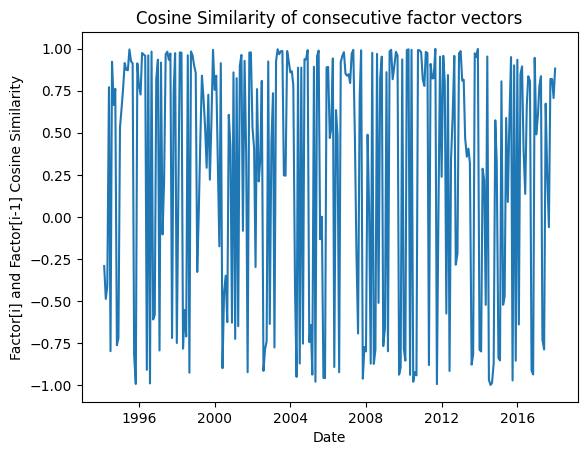

In [156]:
def cosine_similarity_between_cols(df):

    similarities = [np.nan] 

    for i in range(1, len(df.columns)):
        vec1 = df.iloc[:,i - 1].values
        vec2 = df.iloc[:,i].values

        norm_vec1 = np.linalg.norm(vec1)
        norm_vec2 = np.linalg.norm(vec2)

        similarity = np.dot(vec1, vec2) / (norm_vec1 * norm_vec2)
        similarities.append(similarity)

    return pd.Series(similarities, index=df.columns)


plt.plot(cosine_similarity_between_cols(Factors))
plt.title('Cosine Similarity of consecutive factor vectors')
plt.xlabel('Date')
plt.ylabel('Factor[i] and Factor[i-1] Cosine Similarity')
# plt.grid(True)

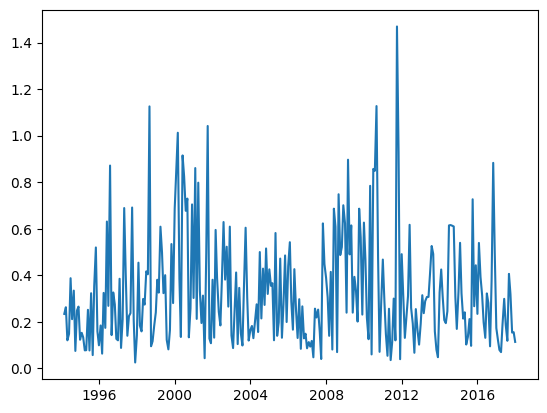

In [157]:
def distance_between_cols(df):

    distances = [np.nan] 

    for i in range(1, len(df.columns)):
        vec1 = df.iloc[:,i - 1].values
        vec2 = df.iloc[:,i].values

        distance = np.linalg.norm(vec2 - vec1)
        distances.append(distance)
    return pd.Series(distances, index=df.columns)

plt.plot(distance_between_cols(Factors))

In [158]:
Factors.mean(axis=1)

0    0.126032
1    0.011440
2    0.025769
3    0.008893
4    0.006306
dtype: float64

In [159]:
Factors.std(axis=1)

0    0.274629
1    0.104199
2    0.042007
3    0.045034
4    0.035426
dtype: float64

In [160]:
# Switch for analysisn snp1500, full stock panel
# X_train_sub_sample,y_train_sub_sample = X,y


In [161]:
# Analysis
def get_prediction_df(Gamma,Factors,X_train_sub_sample,y_train_sub_sample):
    dfs = []
    Factors_pred = Factors.copy(deep=True)
    for date in range(len(Factors_pred.columns)):
        predictive_factors = Factors_pred.iloc[:,date].values.reshape((-1,1))
        pred_X = X_train_sub_sample.loc[X_train_sub_sample.index.get_level_values(1)==Factors_pred.columns[date]]
        y_pred = np.squeeze(pred_X.dot(Gamma).dot(predictive_factors))
        dfs+= [y_pred]

    sample_y = y_train_sub_sample.copy()
    sample_y['pred'] = pd.concat(dfs)
    sample_y = sample_y.dropna()
    return sample_y

sample_y = get_prediction_df(Gamma,Factors,X_train_sub_sample,y_train_sub_sample)



In [162]:
r2_score(sample_y['lagged_ret'],sample_y['pred'])

0.1629566598317267

In [163]:
def rolling_r2(window,y):

    unique_dates = y.index.get_level_values(1).unique()
    rolling_r2 = []
    for i in tqdm(range(window-1,len(unique_dates))):
        start_date = unique_dates[i-window+1]
        end_date = unique_dates[i]
        sub_sample =  y.loc[(y.index.get_level_values(1)<=start_date) & (y.index.get_level_values(1)<=end_date)]
        rolling_r2 += [{'date':end_date,f'r2_{window}': r2_score(sub_sample['lagged_ret'],sub_sample['pred'])}]
    return pd.DataFrame(rolling_r2)




100%|██████████| 157/157 [00:00<00:00, 202.50it/s]


Text(0, 0.5, 'R2')

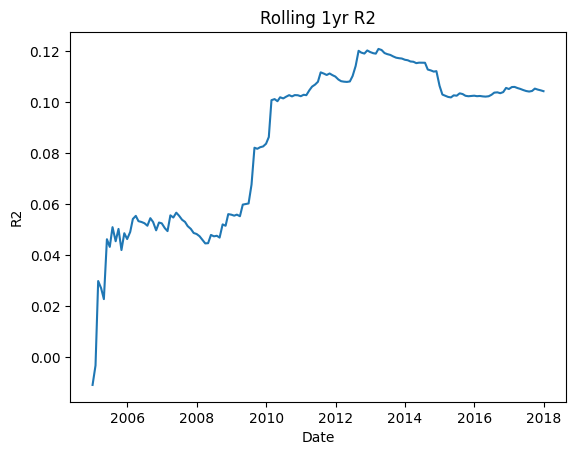

In [202]:
stats = rolling_r2(12,sample_y).set_index('date')

plt.plot(stats['r2_12'])
plt.title('Rolling 1yr R2')
plt.xlabel('Date')
plt.ylabel('R2')

## Why is that the model is having good r2 in later stages? Refitting after 2004


In [165]:
filter_date = pd.to_datetime("2004-01-01")
X_2004 = X.loc[X.index.get_level_values(1)>=filter_date]
y_2004 = y.loc[y.index.get_level_values(1)>=filter_date]

In [166]:
model_2 = ipca.InstrumentedPCA(n_factors=5, intercept=True)
model_2 = model_2.fit(X = X_2004,y=y_2004)
Gamma_2, Factors_2 = model_2.get_factors(label_ind=True)

The panel dimensions are:
n_samples: 6910 , L: 20 , T: 168


[========================================================================] 100%


Step 1 - Aggregate Update: 0.8561798109787435
Step 2 - Aggregate Update: 0.8578736716532084
Step 3 - Aggregate Update: 0.16979626912246792
Step 4 - Aggregate Update: 0.04480495505341729
Step 5 - Aggregate Update: 0.0316105413047168
Step 6 - Aggregate Update: 0.029413048302229988
Step 7 - Aggregate Update: 0.0369775670858557
Step 8 - Aggregate Update: 0.04099677493560505
Step 9 - Aggregate Update: 0.04204967557322298
Step 10 - Aggregate Update: 0.04070220660392354
Step 11 - Aggregate Update: 0.03759915522455498
Step 12 - Aggregate Update: 0.03342676759842611
Step 13 - Aggregate Update: 0.028810576018818757
Step 14 - Aggregate Update: 0.024234607471306013
Step 15 - Aggregate Update: 0.021289199326751912
Step 16 - Aggregate Update: 0.019520033294392586
Step 17 - Aggregate Update: 0.017614415373407688
Step 18 - Aggregate Update: 0.01569481831275918
Step 19 - Aggregate Update: 0.013845113862872266
Step 20 - Aggregate Update: 0.012117142796246871
Step 21 - Aggregate Update: 0.010538645268125

In [167]:
for i in range(len(Gamma.columns)):
    print(np.dot(Gamma.iloc[:,i],Gamma_2.iloc[:,i])/((np.linalg.norm(Gamma.iloc[:,i])* np.linalg.norm(Gamma_2.iloc[:,i]))))

0.970680979436162
0.8841221098717567
0.3173698977251131
-0.5192608333240052
0.14541600783459727


In [168]:

X_train_sub_sample,y_train_sub_sample = X_2004,y_2004

sample_y = get_prediction_df(Gamma_2,Factors_2,X_train_sub_sample,y_train_sub_sample)
r2_score(sample_y['lagged_ret'],sample_y['pred'])

0.1003705463862582

100%|██████████| 157/157 [00:00<00:00, 233.16it/s]


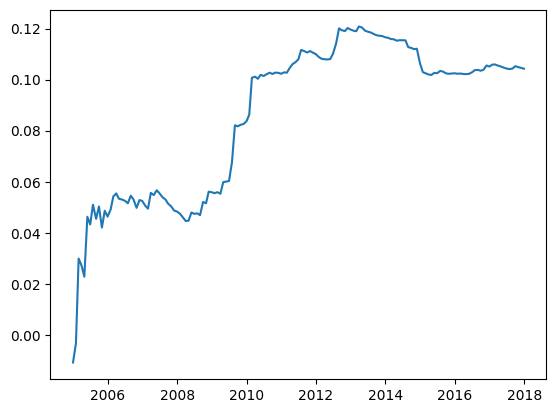

In [169]:

stats = rolling_r2(12,sample_y).set_index('date')

plt.plot(stats['r2_12'])

Explainability of returns by these factors is changing over times. Even with reduced training data the factors explain the returns better in the later stages of the curve. Why?


# Predictive Performance (Full sample)

In [170]:
Gamma_fixed = Gamma.values

In [171]:



X_test = crsp_features_test.loc[:,x_columns]
y_test = crsp_features_test.loc[:,y_column]

In [172]:
dfs = []

out_dates = crsp_features_test.index.get_level_values(1)
Factors_pred = Factors.copy(deep=True).values
X_prev =  None
for date in tqdm(out_dates.unique()):
    # prediction using prev_factors and current observed features

    # predictive_factors = np.mean(Factors_pred[:,:-3],axis=1).reshape((-1,1))
    predictive_factors = np.mean(Factors_pred,axis=1).reshape((-1,1))
    # predictive_factors = np.mean(Factors_pred[:,:-1],axis=1).reshape((-1,1))
    # predictive_factors = Factors_pred[:,-1].reshape((-1,1))

    
    X_current = X_test.loc[X_test.index.get_level_values(1)==date]
    y_pred = np.squeeze(X_current.dot(Gamma_fixed).dot(predictive_factors))
    dfs+= [y_pred]

    # estimating new factors using current features and next returns


    y_next = y_test.loc[y_test.index.get_level_values(1)==date,'lagged_ret']
    val_obs = X_current.shape[0]
    ipca_Q = (X_current.T.dot(y_next)/val_obs).squeeze()
    ipca_W = X_current.T.dot(X_current)/val_obs
    if model.PSF:
        factors_next = ipca._Ft_fit_PSF_portfolio(Gamma_fixed,ipca_W,ipca_Q,np.array([1]),n_factors,n_factors+np.shape(model.PSF)[0])
        Factors_pred = np.concatenate([Factors_pred,np.append(factors_next,1).reshape((-1,1))],axis=1)
    else:
        factors_next = ipca._Ft_fit_portfolio(Gamma_fixed,ipca_W,ipca_Q)
        Factors_pred = np.concatenate([Factors_pred,factors_next.reshape((-1,1))],axis=1)
    



100%|██████████| 83/83 [00:00<00:00, 474.94it/s]


In [173]:
# dfs = []

# out_dates = crsp_features_test.index.get_level_values(1)
# Factors_pred = Factors.copy(deep=True).values
# X_prev =  None
# for date in tqdm(out_dates.unique()):
#     # prediction using prev_factors and current observed features

#     # predictive_factors = np.mean(Factors_pred[:,:-3],axis=1).reshape((-1,1))
#     predictive_factors = np.mean(Factors_pred,axis=1).reshape((-1,1))
#     # predictive_factors = np.mean(Factors_pred[:,:-1],axis=1).reshape((-1,1))
#     # predictive_factors = Factors_pred[:,-1].reshape((-1,1))

    
#     X_current = X_test.loc[X_test.index.get_level_values(1)==date]
#     y_pred = np.squeeze(X_current.dot(Gamma_fixed).dot(predictive_factors))
#     dfs+= [y_pred]

#     # estimating new factors using current features and next returns
#     X = crsp_features.loc[crsp_features.index.get_level_values(1)==date].loc[:,x_columns]
#     y = crsp_features.loc[crsp_features.index.get_level_values(1)==date].loc[:,y_column]

#     # y_next = y_test.loc[y_test.index.get_level_values(1)==date,'lagged_ret']
#     val_obs = X.shape[0]
#     ipca_Q = (X.T.dot(y)/val_obs).squeeze()
#     ipca_W = X.T.dot(X)/val_obs
#     if model.PSF:
#         factors_next = ipca._Ft_fit_PSF_portfolio(Gamma_fixed,ipca_W,ipca_Q,np.array([1]),n_factors,n_factors+np.shape(model.PSF)[0])
#         Factors_pred = np.concatenate([Factors_pred,np.append(factors_next,1).reshape((-1,1))],axis=1)
#     else:
#         factors_next = ipca._Ft_fit_portfolio(Gamma_fixed,ipca_W,ipca_Q)
#         Factors_pred = np.concatenate([Factors_pred,factors_next.reshape((-1,1))],axis=1)




In [174]:
y_test['pred'] = pd.concat(dfs)
y_test = y_test.dropna()

# Predictive $R^2$  (1 step ahead)

In [175]:
r2_score(y_test['lagged_ret'],y_test['pred'])

0.0009530641763663139

# Predictive Performance (S&P 1500)

In [177]:
X_test = crsp_features_test.loc[crsp_features_test.index.get_level_values(0).isin(snp_ticker_df.index),x_columns]
y_test = crsp_features_test.loc[crsp_features_test.index.get_level_values(0).isin(snp_ticker_df.index),y_column]
dfs = []

out_dates = crsp_features_test.index.get_level_values(1)
Factors_pred = Factors.copy(deep=True).values
X_prev =  None
for date in tqdm(out_dates.unique()):
    # prediction using prev_factors and current observed features

    # predictive_factors = np.mean(Factors_pred[:,:-3],axis=1).reshape((-1,1))
    predictive_factors = np.mean(Factors_pred,axis=1).reshape((-1,1))
    # predictive_factors = np.mean(Factors_pred[:,:-1],axis=1).reshape((-1,1))
    # predictive_factors = Factors_pred[:,-1].reshape((-1,1))

    
    X_current = X_test.loc[X_test.index.get_level_values(1)==date]
    y_pred = np.squeeze(X_current.dot(Gamma_fixed).dot(predictive_factors))
    dfs+= [y_pred]

    # estimating new factors using current features and next returns

    X = crsp_features.loc[crsp_features.index.get_level_values(1)==date].loc[:,x_columns]
    y = crsp_features.loc[crsp_features.index.get_level_values(1)==date].loc[:,y_column]

    # y_next = y_test.loc[y_test.index.get_level_values(1)==date,'lagged_ret']
    val_obs = X.shape[0]
    ipca_Q = (X.T.dot(y)/val_obs).squeeze()
    ipca_W = X.T.dot(X)/val_obs
    if model.PSF:
        factors_next = ipca._Ft_fit_PSF_portfolio(Gamma_fixed,ipca_W,ipca_Q,np.array([1]),n_factors,n_factors+np.shape(model.PSF)[0])
        Factors_pred = np.concatenate([Factors_pred,np.append(factors_next,1).reshape((-1,1))],axis=1)
    else:
        factors_next = ipca._Ft_fit_portfolio(Gamma_fixed,ipca_W,ipca_Q)
        Factors_pred = np.concatenate([Factors_pred,factors_next.reshape((-1,1))],axis=1)
    


y_test['pred'] = pd.concat(dfs)
y_test = y_test.dropna()
# Predictive $R^2$  (1 step ahead)
r2_score(y_test['lagged_ret'],y_test['pred'])

100%|██████████| 83/83 [00:00<00:00, 157.96it/s]


-0.004647700132143662

# BackTest Analysis

# NDCG

In [178]:
def calculate_daily_ndcg(df, k=None):
    """
    --------
    daily_ndcg : pandas.DataFrame
        DataFrame with date and ndcg score
    avg_ndcg : float
        Average NDCG score across all dates
    """
    
    
    df_reset = df.reset_index()
    
    date_groups = df_reset.groupby('date')
    
    daily_ndcg = []
    
    for date, group in date_groups:
        # Create rankings for actual returns (higher return = better rank)
        group = group.copy()  # Create a copy to avoid SettingWithCopyWarning
        group['actual_rank'] = group['lagged_ret'].rank(ascending=False)
        
        # Create rankings for predicted returns (higher prediction = better rank)
        group['pred_rank'] = group['pred'].rank(ascending=False)
        
        # Sort by pred_rank to get order of predictions
        sorted_by_pred = group.sort_values('pred_rank')
        
        # For NDCG calculation:
        # y_true: actual ranks in predicted order (lower is better)
        # The best rank is 1, so we need to invert the scale for NDCG
        max_rank = group['actual_rank'].max()
        y_true = (max_rank + 1 - sorted_by_pred['actual_rank']).values.reshape(1, -1)
        
        # Perfect ranking would have actual_rank in ascending order
        # The best rank is 1, so we need to invert the scale for NDCG
        y_ideal = np.sort(y_true[0])[::-1].reshape(1, -1)
        
        # Calculate NDCG
        if k is not None and k < len(y_true[0]):
            ndcg = ndcg_score(y_ideal, y_true, k=k)
        else:
            ndcg = ndcg_score(y_ideal, y_true)
        
        daily_ndcg.append({'date': date, 'ndcg': ndcg})
    
    # Convert to DataFrame
    daily_ndcg_df = pd.DataFrame(daily_ndcg)
    daily_ndcg_df = daily_ndcg_df.set_index('date')
    
    # Calculate average NDCG
    avg_ndcg = daily_ndcg_df['ndcg'].mean()
    
    return daily_ndcg_df, avg_ndcg

In [179]:
def calculate_daily_ndcg_top_bottom(df, k=10):
    """
 
    daily_ndcg : pandas.DataFrame
        DataFrame with date, top_ndcg, bottom_ndcg, and overall_ndcg scores
    avg_scores : dict
        Dictionary with average NDCG scores for top, bottom, and overall
    """
    # Make sure we're working with a MultiIndex DataFrame
    if not isinstance(df.index, pd.MultiIndex):
        raise ValueError("DataFrame should have a MultiIndex with permno and date")
    
    # Reset index to get date as a column
    df_reset = df.reset_index()
    
    # Ensure date is in datetime format
    if not pd.api.types.is_datetime64_any_dtype(df_reset['date']):
        df_reset['date'] = pd.to_datetime(df_reset['date'])
    
    # Group by date
    date_groups = df_reset.groupby('date')
    
    # Store daily NDCG scores
    daily_ndcg = []
    
    for date, group in date_groups:
        # Skip dates with too few stocks
        if len(group) < 2*k:
            continue
            
        # Create rankings for actual returns (higher return = better rank)
        group = group.copy()  # Create a copy to avoid SettingWithCopyWarning
        group['actual_rank'] = group['lagged_ret'].rank(ascending=False)
        
        # Create rankings for predicted returns (higher prediction = better rank)
        group['pred_rank'] = group['pred'].rank(ascending=False)
        
        # Sort by predicted rank
        sorted_by_pred = group.sort_values('pred_rank')
        
        # For NDCG calculation:
        # Convert ranks to relevance scores (lower rank = higher relevance)
        max_rank = group['actual_rank'].max()
        relevance_scores = max_rank + 1 - sorted_by_pred['actual_rank']
        
        # Get top k predictions (lowest pred_rank values)
        top_k_pred = sorted_by_pred.head(k)
        top_k_relevance = (max_rank + 1 - top_k_pred['actual_rank']).values.reshape(1, -1)
        
        # Get bottom k predictions (highest pred_rank values)
        bottom_k_pred = sorted_by_pred.tail(k)
        bottom_k_relevance = (max_rank + 1 - bottom_k_pred['actual_rank']).values.reshape(1, -1)
        
        # Calculate ideal relevance ordering (descending)
        top_k_ideal = np.sort(top_k_relevance[0])[::-1].reshape(1, -1)
        bottom_k_ideal = np.sort(bottom_k_relevance[0])[::-1].reshape(1, -1)
        
        # Full dataset for overall NDCG
        full_relevance = relevance_scores.values.reshape(1, -1)
        full_ideal = np.sort(full_relevance[0])[::-1].reshape(1, -1)
        
        # Calculate NDCG scores
        top_ndcg = ndcg_score(top_k_ideal, top_k_relevance)
        bottom_ndcg = ndcg_score(bottom_k_ideal, bottom_k_relevance)
        overall_ndcg = ndcg_score(full_ideal, full_relevance)
        
        daily_ndcg.append({
            'date': date, 
            'top_ndcg': top_ndcg, 
            'bottom_ndcg': bottom_ndcg,
            'overall_ndcg': overall_ndcg
        })
    
    # Convert to DataFrame
    daily_ndcg_df = pd.DataFrame(daily_ndcg)
    
    # Handle empty results
    if len(daily_ndcg_df) == 0:
        return pd.DataFrame(), {'top_avg': None, 'bottom_avg': None, 'overall_avg': None}
    
    daily_ndcg_df = daily_ndcg_df.set_index('date')
    
    # Calculate average NDCG scores
    avg_scores = {
        'top_avg': daily_ndcg_df['top_ndcg'].mean(),
        'bottom_avg': daily_ndcg_df['bottom_ndcg'].mean(),
        'overall_avg': daily_ndcg_df['overall_ndcg'].mean()
    }
    
    return daily_ndcg_df, avg_scores

In [180]:
# a,b = calculate_daily_ndcg(y_test,k=10)
a,b = calculate_daily_ndcg_top_bottom(y_test,k=10)

In [181]:
a.describe()

,top_ndcg,bottom_ndcg,overall_ndcg
count,83.000000,83.000000,83.000000
mean,0.816259,0.853128,0.924648
std,0.119279,0.078192,0.013174
min,0.496637,0.590284,0.888817
25%,0.736370,0.804272,0.913042
50%,0.849204,0.868970,0.924908
75%,0.897346,0.904595,0.933783
max,0.993044,0.972247,0.949606


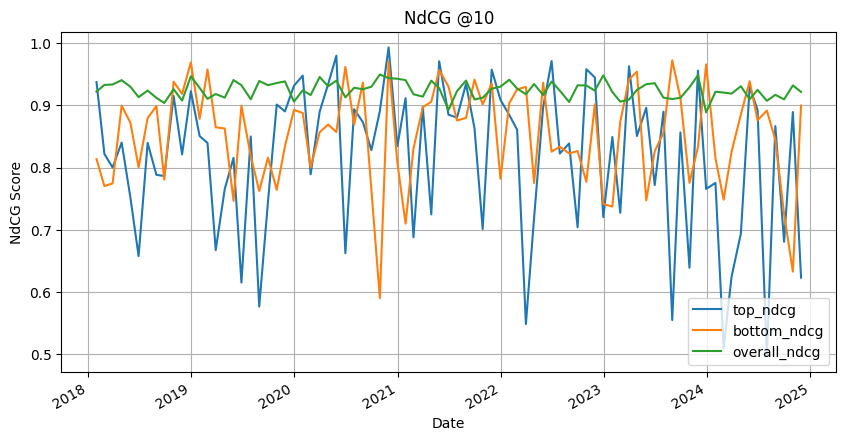

In [182]:

fig, ax = plt.subplots(figsize=(10, 5)) 
a.plot(ax=ax)  

ax.set_xlabel("Date")
ax.set_ylabel("NdCG Score") 
ax.set_title("NdCG @10")
ax.legend(loc='lower right')  
ax.grid(True)

plt.show()

# Stock Decile Portfolios

In [183]:
def long_short_portfolio_pnl(df, k,snp_ticker_df):
   
    daily_pnl = []
    dates = []
    unique_dates = df.index.get_level_values('date').unique()
    picks = pd.DataFrame(index= unique_dates)

    for date in unique_dates:
        daily_data = df.xs(date, level='date')
        daily_data = daily_data.sort_values(by='pred', ascending=False)

        long_stocks = daily_data.head(k)
        short_stocks = daily_data.tail(k)

        picks.loc[date,[f'Long_{i+1}' for i in range(k)]] = long_stocks.index.map(lambda x: snp_ticker_df[snp_ticker_df.index==x]['ticker'].iloc[0])
        picks.loc[date,[f'Short_{i+1}' for i in range(k)]] = short_stocks.index.map(lambda x: snp_ticker_df[snp_ticker_df.index==x]['ticker'].iloc[0])


        picks.loc[date,[f'Long_{i+1}_pnl' for i in range(k)]] = np.array(long_stocks['lagged_ret'])
        picks.loc[date,[f'Short_{i+1}_pnl' for i in range(k)]] = -np.array(short_stocks['lagged_ret'])

        long_pnl = long_stocks['lagged_ret'].sum()
        short_pnl = -short_stocks['lagged_ret'].sum()  

        picks.loc[date,"Long_only_pnl"] = long_pnl/(2*k)
        picks.loc[date,"Short_only_pnl"] = short_pnl/(2*k)
        picks.loc[date,'Portfolio_pnl'] = (long_pnl + short_pnl)/(2*k)

        daily_pnl.append((long_pnl + short_pnl)/(2*k))
        dates.append(date)


    avg_return = np.mean(daily_pnl)*12
    std_dev = np.std(daily_pnl)*np.sqrt(12)
    sharpe_ratio = avg_return / std_dev 

    stats =  pd.Series({
        'sharpe_ratio': sharpe_ratio,
        'avg_return': avg_return,
        'std_dev': std_dev
    })

    pnl_df = pd.DataFrame({'date': dates, 'pnl': daily_pnl})
    return pnl_df,stats,picks



In [184]:
for i in range(10,60,10):
    pnl_df,stats,picks = long_short_portfolio_pnl(y_test,i,snp_ticker_df)
    print(f"Sharpe Ratio of long_short@{i} is {stats.loc['sharpe_ratio']}")

Sharpe Ratio of long_short@10 is 1.5996983841463068
Sharpe Ratio of long_short@20 is 1.861261594729127


/var/folders/vf/gw1t6f4j3mv84kp8kpw4j_bw0000gn/T/ipykernel_10162/429398311.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  picks.loc[date,"Long_only_pnl"] = long_pnl/(2*k)
/var/folders/vf/gw1t6f4j3mv84kp8kpw4j_bw0000gn/T/ipykernel_10162/429398311.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  picks.loc[date,"Short_only_pnl"] = short_pnl/(2*k)
/var/folders/vf/gw1t6f4j3mv84kp8kpw4j_bw0000gn/T/ipykernel_10162/429398311.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fram

Sharpe Ratio of long_short@30 is 1.6820070449216455


/var/folders/vf/gw1t6f4j3mv84kp8kpw4j_bw0000gn/T/ipykernel_10162/429398311.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  picks.loc[date,"Long_only_pnl"] = long_pnl/(2*k)
/var/folders/vf/gw1t6f4j3mv84kp8kpw4j_bw0000gn/T/ipykernel_10162/429398311.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  picks.loc[date,"Short_only_pnl"] = short_pnl/(2*k)
/var/folders/vf/gw1t6f4j3mv84kp8kpw4j_bw0000gn/T/ipykernel_10162/429398311.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fram

Sharpe Ratio of long_short@40 is 1.484033832187707


/var/folders/vf/gw1t6f4j3mv84kp8kpw4j_bw0000gn/T/ipykernel_10162/429398311.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  picks.loc[date,"Long_only_pnl"] = long_pnl/(2*k)
/var/folders/vf/gw1t6f4j3mv84kp8kpw4j_bw0000gn/T/ipykernel_10162/429398311.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  picks.loc[date,"Short_only_pnl"] = short_pnl/(2*k)
/var/folders/vf/gw1t6f4j3mv84kp8kpw4j_bw0000gn/T/ipykernel_10162/429398311.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fram

Sharpe Ratio of long_short@50 is 1.4520873949758053


# Analyzing top 10 portfolio

In [185]:
pnl_df,stats,picks = long_short_portfolio_pnl(y_test,10,snp_ticker_df)
stats

sharpe_ratio    1.599698
avg_return      0.237438
std_dev         0.148427
dtype: float64

# Stocks picked by Id, count plot

>> Long_1 Is the predicted stock with the highest return
>> Long_2 Is the predicted stock with the highest return ,Long_3  and so on..

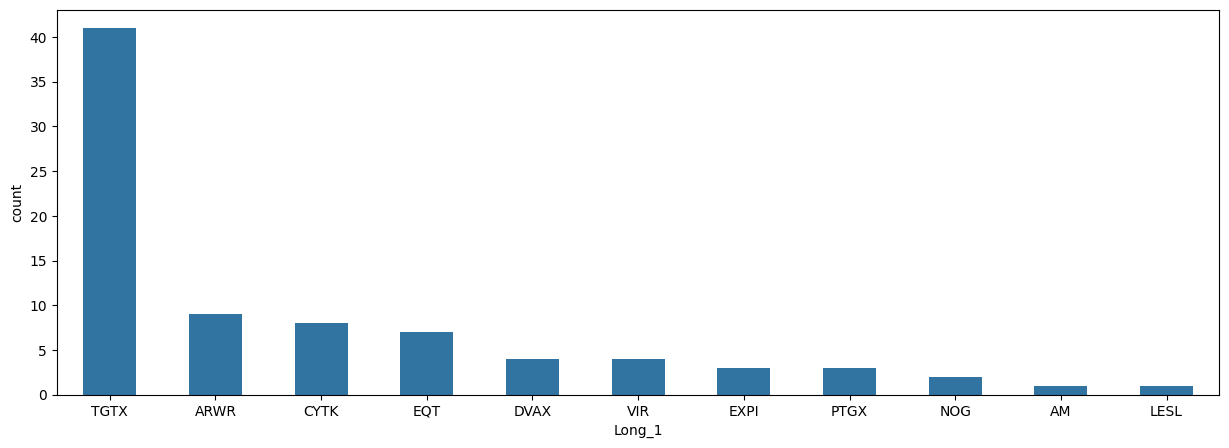

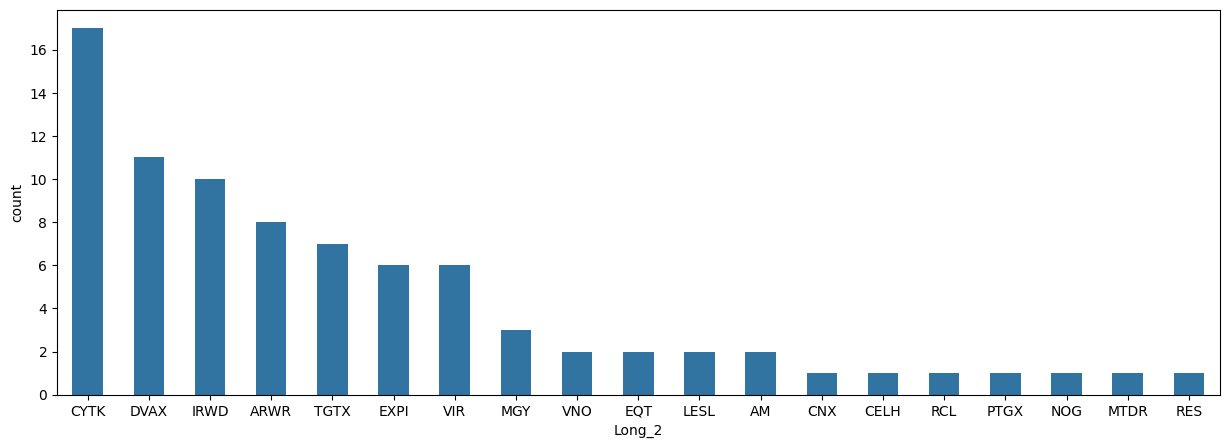

In [186]:
for i in range(1,3):
    plt.figure(figsize=(15, 5))
    sns.barplot(picks[f"Long_{i}"].value_counts(),width=0.5)

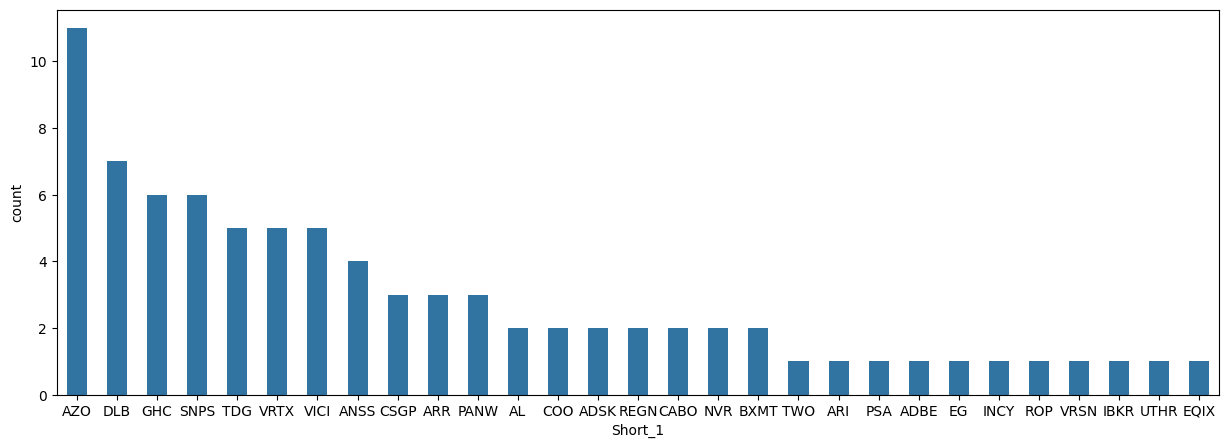

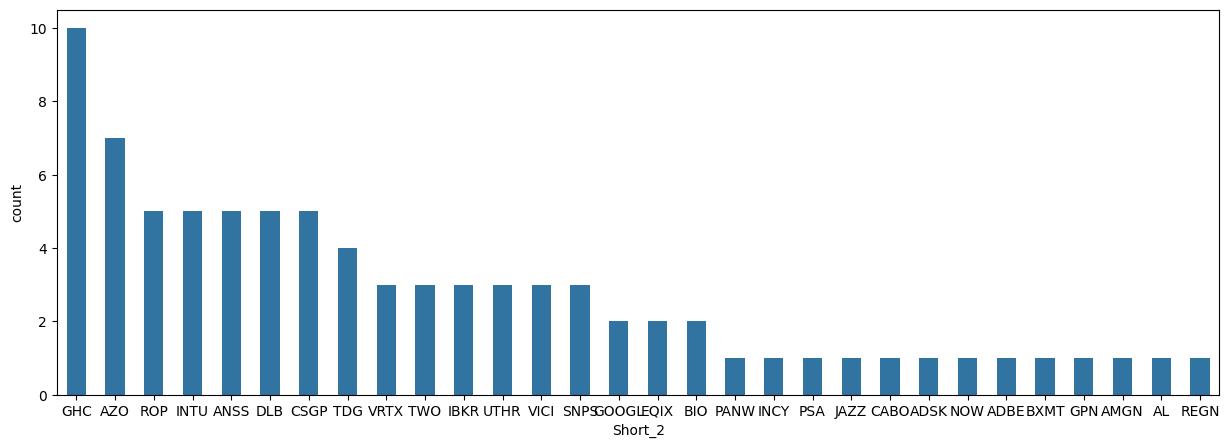

In [204]:
for i in range(1,3):
    plt.figure(figsize=(15, 5))
    sns.barplot(picks[f"Short_{i}"].value_counts(),width=0.5)

# Markets beta/IR

In [187]:
pnl_cols = [col for col in picks.columns if col.endswith("_pnl")]

In [188]:
def LFPM_TS(assets, factors, annualize = 12, name = 'asset', treynor = False, mkt_name = 'vwretd'):
    
    if isinstance(assets,pd.Series):
        assets = pd.DataFrame(assets,columns=name)
    
    model_output = pd.DataFrame()
    stats_output = pd.DataFrame()
    
    x = sm.add_constant(factors)
    
    for asset in assets.columns:
        
        y = assets[asset]
        model = sm.OLS(y,x).fit()
        
        model_output[asset] = model.params
        
        mu = y.mean() * annualize
        alpha = model.params[0] * annualize
        sig_ep = model.resid.std() * np.sqrt(annualize)
        IR = alpha / sig_ep
        
        stats_output[asset] = pd.Series(data = [alpha,IR],index = ['Alpha','IR'])
        
        if treynor:
            mkt = model.params[mkt_name]
            TR = mu / mkt
            
            stats_output.loc['Treynor',asset] = TR
    
    model_output = model_output.rename({"x1":'beta'})
        
    return pd.concat([model_output,stats_output],axis=0)

In [189]:
# making them contemperous
mkt_rets = market_df[market_df.index>=pd.to_datetime('2018-01-01')].shift(1).dropna().values

In [190]:
market_stats = LFPM_TS(picks[pnl_cols],mkt_rets)

/var/folders/vf/gw1t6f4j3mv84kp8kpw4j_bw0000gn/T/ipykernel_10162/171690269.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model.params[0] * annualize
/var/folders/vf/gw1t6f4j3mv84kp8kpw4j_bw0000gn/T/ipykernel_10162/171690269.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model.params[0] * annualize
/var/folders/vf/gw1t6f4j3mv84kp8kpw4j_bw0000gn/T/ipykernel_10162/171690269.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, us

Market Neutral as expected, but exposure to other factors like size may not be zero

In [191]:
market_stats[market_stats.columns[::-1]]

,Portfolio_pnl,Short_only_pnl,Long_only_pnl,Short_10_pnl,Short_9_pnl,Short_8_pnl,Short_7_pnl,Short_6_pnl,Short_5_pnl,Short_4_pnl,...,Long_10_pnl,Long_9_pnl,Long_8_pnl,Long_7_pnl,Long_6_pnl,Long_5_pnl,Long_4_pnl,Long_3_pnl,Long_2_pnl,Long_1_pnl
const,0.018918,-0.005569,0.024486,-0.017361,-0.003183,-0.011739,-0.005951,0.001406,-0.022179,0.001702,...,0.053396,0.056399,0.037513,0.044952,0.038471,0.051001,0.053005,0.073916,0.015960,0.065113
beta,0.077372,0.059965,0.017407,0.152195,0.091002,0.323016,0.118119,-0.139343,0.232922,-0.064922,...,-0.577424,-0.509105,-0.315687,-0.255381,1.178016,-0.625869,0.199695,1.259568,-0.204761,0.199090
Alpha,0.227011,-0.066825,0.293836,-0.208328,-0.038202,-0.140864,-0.071412,0.016872,-0.266149,0.020420,...,0.640753,0.676785,0.450156,0.539429,0.461648,0.612017,0.636060,0.886989,0.191525,0.781360
IR,1.526501,-0.725852,1.570121,-0.672478,-0.107579,-0.483205,-0.261667,0.053523,-0.928734,0.066119,...,0.973842,0.928127,0.747143,0.815804,0.517561,0.989764,0.897623,0.971828,0.280662,0.942886


# Decile Sharpes

In [192]:
def stats(returns,annualize = 12, q = 0.05):

    output = returns.agg(['mean','std'])
    output.loc['sharpe'] = output.loc['mean'] / output.loc['std']
    output.loc['mean'] *= annualize
    output.loc['std'] *= np.sqrt(annualize)
    output.loc['sharpe'] *= np.sqrt(annualize)
    output.loc['skew'] = returns.skew()
    output.loc['kurtosis'] = returns.kurtosis()
    output.loc['var_%s'%q] = returns.quantile(q)
    output.loc['cvar_%s'%q] = returns[returns<= returns.quantile(q)].mean()
    return output.T

In [193]:
stats(picks[pnl_cols])


,mean,std,sharpe,skew,kurtosis,var_0.05,cvar_0.05
Long_1_pnl,0.808190,0.829422,0.974401,0.319882,1.014005,-0.215474,-0.377793
Long_2_pnl,0.163930,0.683346,0.239893,0.630952,-0.036107,-0.254598,-0.311375
Long_3_pnl,1.056736,0.938968,1.125423,2.082040,8.048230,-0.242007,-0.278627
Long_4_pnl,0.662972,0.709468,0.934464,1.548826,3.982488,-0.201770,-0.243141
Long_5_pnl,0.527672,0.627982,0.840266,0.471693,-0.026295,-0.189998,-0.240923
Long_6_pnl,0.620404,0.915505,0.677663,2.963434,13.155274,-0.238952,-0.306440
Long_7_pnl,0.505012,0.662734,0.762013,1.281069,4.816947,-0.177965,-0.277273
Long_8_pnl,0.407612,0.605033,0.673702,0.446009,0.093686,-0.192152,-0.261099
Long_9_pnl,0.608175,0.734622,0.827875,1.806620,6.857128,-0.199763,-0.280056
Long_10_pnl,0.562936,0.665686,0.845648,1.220184,2.976154,-0.177233,-0.234424


# Winrates

In [194]:
winRates= pd.DataFrame()
for i in range(1,11):
    winRates.loc[i,f"Long"] = (picks[f"Long_{i}_pnl"]>0).mean()
    winRates.loc[i,f"Short"] = (picks[f"Short_{i}_pnl"]>0).mean()

winRates.loc['All',f"Long"] = (picks[f"Long_only_pnl"]>0).mean()
winRates.loc['All',f"Short"] = (picks[f"Short_only_pnl"]>0).mean()
winRates.loc['Portfolio','Long'] = (picks['Portfolio_pnl']>0).mean()
winRates.loc['Portfolio','Short'] = (picks['Portfolio_pnl']>0).mean()


In [195]:
winRates

,Long,Short
1,0.554217,0.421687
2,0.445783,0.469880
3,0.590361,0.409639
4,0.590361,0.481928
5,0.542169,0.397590
6,0.554217,0.493976
7,0.542169,0.433735
8,0.542169,0.530120
9,0.506024,0.481928
10,0.590361,0.409639


# Other Portfolio Metrics

In [196]:
pnl_df['cumulative_return'] = (1 + pnl_df["pnl"].fillna(0)).cumprod() - 1
pnl_df['drawdown'] = (pnl_df['cumulative_return'] - pnl_df['cumulative_return'].cummax()) / pnl_df['cumulative_return'].cummax()
pnl_df['max_drawdown'] = pnl_df['drawdown'].min()


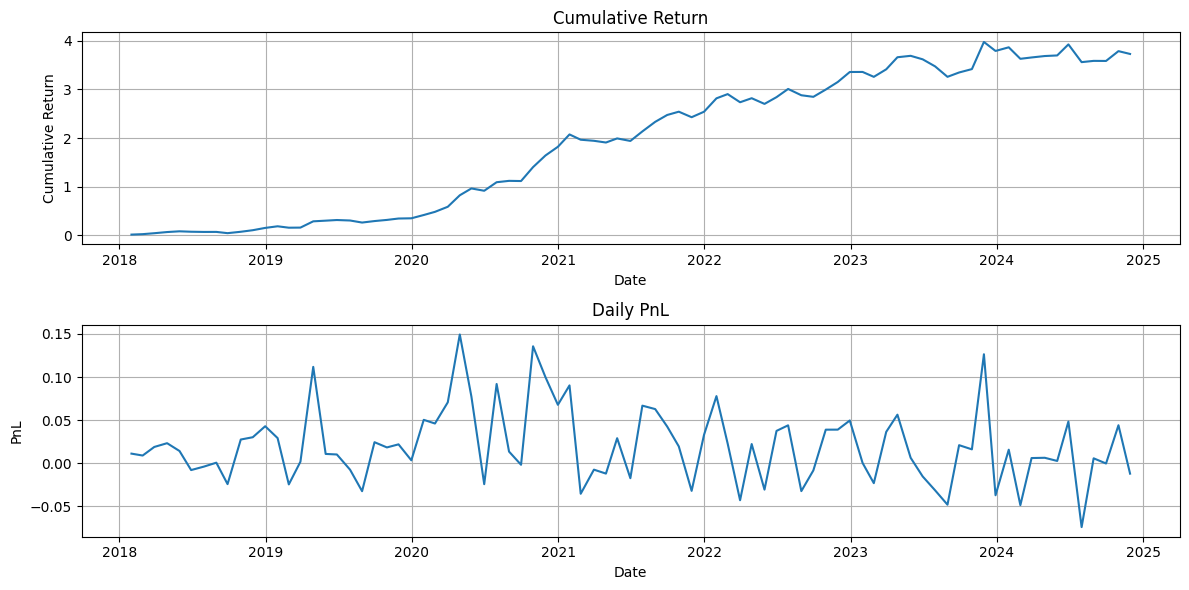

In [197]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(pnl_df['date'], pnl_df['cumulative_return']) 
plt.title('Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(pnl_df['date'], pnl_df['pnl']) 
plt.title('Daily PnL')
plt.xlabel('Date')
plt.ylabel('PnL')
plt.grid(True)

plt.tight_layout()
plt.show()


In [199]:
pnl_df

,date,pnl,cumulative_return,drawdown,max_drawdown
0,2018-01-31,0.011118,0.011118,0.000000,-0.483466
1,2018-02-28,0.008912,0.020129,0.000000,-0.483466
2,2018-03-29,0.018864,0.039372,0.000000,-0.483466
3,2018-04-30,0.023233,0.063520,0.000000,-0.483466
4,2018-05-31,0.014174,0.078594,0.000000,-0.483466
...,...,...,...,...,...
78,2024-07-31,-0.074112,3.562831,-0.104435,-0.483466
79,2024-08-30,0.005684,3.588764,-0.097916,-0.483466
80,2024-09-30,-0.000326,3.587270,-0.098292,-0.483466
81,2024-10-31,0.044054,3.789356,-0.047495,-0.483466


In [200]:
pnl_df['drawdown'].idxmin()

8

In [201]:
pnl_df.head(10)

,date,pnl,cumulative_return,drawdown,max_drawdown
0,2018-01-31,0.011118,0.011118,0.000000,-0.483466
1,2018-02-28,0.008912,0.020129,0.000000,-0.483466
2,2018-03-29,0.018864,0.039372,0.000000,-0.483466
3,2018-04-30,0.023233,0.063520,0.000000,-0.483466
4,2018-05-31,0.014174,0.078594,0.000000,-0.483466
5,2018-06-29,-0.007948,0.070022,-0.109072,-0.483466
6,2018-07-31,-0.003934,0.065812,-0.162636,-0.483466
7,2018-08-31,0.000616,0.066468,-0.154282,-0.483466
8,2018-09-28,-0.024259,0.040597,-0.483466,-0.483466
9,2018-10-31,0.027484,0.069196,-0.119573,-0.483466
